Facies classification is one of the most important tasks that geoscientists work on development and exploration projects. Sedimentary facies reflect particular physical, chemical, and biological condition that unit experienced during sedimentation process. To study these facies, rock samples are required. In this study, it is practiced to train various machine learning algorithms to predict facies from well log data. The dataset for this study comes from [Hugoton and Panoma Fields](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) in North America which was used in class exercise in The University of Kansas [(Dubois et. al, 2007)](https://www.sciencedirect.com/science/article/pii/S0098300406001956?via%3Dihub). It consists of log data of nine wells. We will use these log data to train supervised classifiers in order to predict discrete facies groups. All this implementation is based on [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) libraries. These are:<br>
1) Support vector machines (SVM)<br>
2) Random forest classifier (RFC)<br>
3) K Nearest Neighbors Classifier (KNN)<br>

# BEFORE MODELING

## Data Understanding and Wrangling
The training data stored in CSV format contains 5 wireline log measurements, two indicators and facies label in half foot interval. In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type). We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.


In [ ]:
import pandas as pd

In [ ]:
# read data from csv into python data frame
dataset = pd.read_csv('/content/drive/MyDrive/C-Shale SPWLA 2023/Private/facies_vectors.csv')
dataset

,FORMATION,WELL,DEPTH,GR,ILD_LOG10,DPHI,PHIND,PE,NM_M,RELPOS,FACIES
0,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,3
1,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,3
2,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,3
3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,3
4,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,3
...,...,...,...,...,...,...,...,...,...,...,...
4144,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,5
4145,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,5
4146,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,5
4147,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,5


The Council Grove gas reservoir is located in Kansas. From this carbonate reservoir, nine wells (with 4149 examples) are avaialble. Facies are studied from core samples in every half foot and matched with logging data in well location. Feature variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge.
The seven variables are:<br>
1. __GR__: this wireline logging tools measure gamma emission from formation. Good index for shale content.<br>
2. __ILD_log10__ : this is resistivity measurment which is applicable for identification of reservoir fluid content.<br>
3. __PE__ : photoelectric effect log can be used for lithology (mineral contet of rock) identificaiton.<br>
4. __DeltaPHI__: Phi is porosity index in petrophysics. To measure porosity, there serval methods such as neutron and density. This is differences between them.<br>
5. __PNHIND__: Average of neutron and density log.<br>
6. __NM_M__ :nonmarine-marine indicator<br>
7. __RELPOS__: relative position<br>

The nine discrete facies (classes of rocks) are:
1. __(SS)__   Nonmarine sandstone
2. __(CSiS)__ Nonmarine coarse siltstone
3. __(FSiS)__ Nonmarine fine siltstone
4. __(SiSH)__ Marine siltstone and shale
5. __(MS)__   Mudstone (limestone)
6. __(WS)__   Wackestone (limestone)
7. __(D)__    Dolomite
8. __(PS)__   Packstone-grainstone (limestone)
9. __(BS)__   Phylloid-algal bafflestone (limestone)

Geologically, sometimes the boundray of facies are not clear and could show some transition.The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

### Change WELL and FORMATION into a categorical data type

In [ ]:
dataset.dtypes

FORMATION     object
WELL          object
DEPTH        float64
GR           float64
ILD_LOG10    float64
DPHI         float64
PHIND        float64
PE           float64
NM_M           int64
RELPOS       float64
FACIES         int64
dtype: object

In [ ]:
# change FORMATION and WELL into categorical data type
dataset['FORMATION'] = dataset['FORMATION'].astype('category')
dataset['WELL'] = dataset['WELL'])astype('category')

In [ ]:
dataset.dtypes

FORMATION    category
WELL         category
DEPTH         float64
GR            float64
ILD_LOG10     float64
DPHI          float64
PHIND         float64
PE            float64
NM_M            int64
RELPOS        float64
FACIES          int64
dtype: object

Initially, we have 8 wells

In [ ]:
dataset['WELL'].nunique()

10

In [ ]:
dataset['WELL'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
ALEXANDER D        466
NEWBY              463
LUKE G U           461
SHANKLE            449
KIMZEY A           439
NOLAN              415
CHURCHMAN BIBLE    404
Recruit F9          80
Name: WELL, dtype: int64

### Quick statistical distribution

This is a quick view of the statistical distribution of the input variables. Looking at the count values, most values have 4149 valid values except for PE, which has 3232. In this tutorial we will drop the feature vectors that don't have a valid PE entry.

In [ ]:
dataset.describe()

,DEPTH,GR,ILD_LOG10,DPHI,PHIND,PE,NM_M,RELPOS,FACIES
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000,4149.000000
mean,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,4.503254
std,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644,2.474324
min,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,1.000000
25%,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000,2.000000
50%,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000,4.000000
75%,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000,6.000000
max,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,9.000000


### Drop incomplete data without valid PE entry

In [ ]:
PE_mask = dataset['PE'].notnull().values
dataset = dataset[PE_mask]

In [ ]:
dataset.describe()

,DEPTH,GR,ILD_LOG10,DPHI,PHIND,PE,NM_M,RELPOS,FACIES
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287,4.422030
std,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792,2.504243
min,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000,1.000000
25%,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000,2.000000
50%,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000,4.000000
75%,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250,6.000000
max,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000,9.000000


### Remove a single well to use as blind test later

Apparently, PE reading is not conducted in ALEXANDER D and KIMZEY A well

In [ ]:
dataset['WELL'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
NEWBY              463
LUKE G U           461
SHANKLE            449
NOLAN              415
CHURCHMAN BIBLE    404
Recruit F9          68
ALEXANDER D          0
KIMZEY A             0
Name: WELL, dtype: int64

Remove a single well to use as a blind test later

In [ ]:
blind = dataset[dataset['WELL'] == 'NOLAN']
training = dataset[dataset['WELL'] != 'NOLAN']

In [ ]:
training['WELL'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
NEWBY              463
LUKE G U           461
SHANKLE            449
CHURCHMAN BIBLE    404
Recruit F9          68
ALEXANDER D          0
KIMZEY A             0
NOLAN                0
Name: WELL, dtype: int64

### Plot facies distribution population

We can look at how the various facies are represented by the entire training set. Let's plot a bar chart of the number of training examples for each facies class.

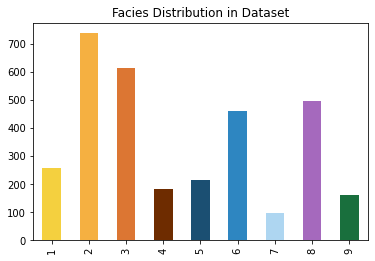

In [ ]:
# populate unique category (and its population)
facies_counts = dataset['FACIES'].value_counts().sort_index()
# facies_counts
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_counts.plot(kind='bar', color=facies_colors, title='Facies Distribution in Dataset')

### Plot log plot form

Let's take a look at the data from individual wells in a more familiar log plot form. We will create plots for the five well log variables, as well as a log for facies labels.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

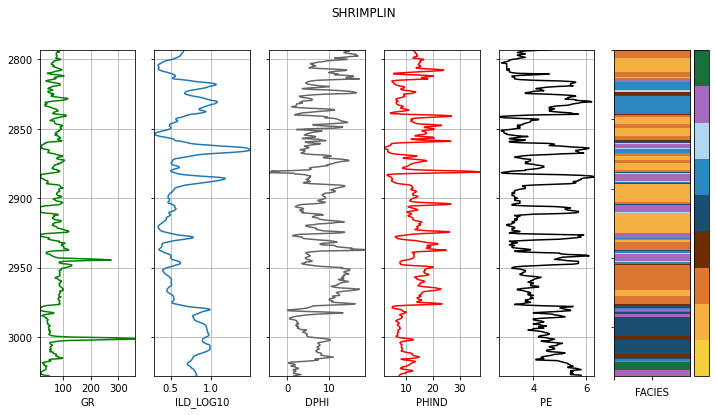

In [ ]:
logs = training[training['WELL'] == 'SHRIMPLIN']
# make sure logs are sorted by depth
logs = logs.sort_values(by='DEPTH')

# set
ztop = logs.DEPTH.min()
zbottom = logs.DEPTH.max()

cmap_facies = colors.ListedColormap(facies_colors[0: len(facies_colors)], 'indexed')

# # create dummy 2D array to plot heatmap facies color
cluster = np.repeat(np.expand_dims(logs['FACIES'].values, 1), 100, 1)

# create plot
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 6))
ax[0].plot(logs.GR, logs.DEPTH, '-g')
ax[1].plot(logs.ILD_LOG10, logs.DEPTH, '-')
ax[2].plot(logs.DPHI, logs.DEPTH, '-', color='0.40')
ax[3].plot(logs.PHIND, logs.DEPTH, '-', color='r')
ax[4].plot(logs.PE, logs.DEPTH, '-', color='black')
im = ax[5].imshow(cluster, aspect='auto', vmin=1, vmax=9, cmap=cmap_facies)

# add suptitle
f.suptitle(logs.iloc[0]['WELL'])

# assign y-axis limits, invert y-axis, and add gridlines
for i in range(len(ax)-1):
  ax[i].set_ylim(ztop, zbottom)
  ax[i].invert_yaxis()
  ax[i].grid()

# remove depth label in y-axis except for the leftmost graph
for i in range(1, len(ax)):
  ax[i].set_yticklabels([])

# set x-axis scale and label
ax[0].set_xlabel("GR")
ax[0].set_xlim(logs.GR.min(),logs.GR.max())
ax[1].set_xlabel("ILD_LOG10")
ax[1].set_xlim(logs.ILD_LOG10.min(),logs.ILD_LOG10.max())
ax[2].set_xlabel("DPHI")
ax[2].set_xlim(logs.DPHI.min(),logs.DPHI.max())
ax[3].set_xlabel("PHIND")
ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
ax[4].set_xlabel("PE")
ax[4].set_xlim(logs.PE.min(),logs.PE.max())
ax[5].set_xlabel('FACIES')
ax[5].set_xticklabels([])

# add color bar for facies
divider = make_axes_locatable(ax[5])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

### Scatter plot for each Facies

In [ ]:
# import seaborn as sns
# sns.pairplot(training.drop(['WELL', 'FORMATION', 'DEPTH', 'NM_M', 'RELPOS'], axis=1), hue='FACIES', palette=facies_colors)

### Get data correlation score

In [ ]:
training.corr('spearman')

,DEPTH,GR,ILD_LOG10,DPHI,PHIND,PE,NM_M,RELPOS,FACIES
DEPTH,1.000000,-0.198123,0.206847,-0.142691,-0.110336,0.290350,0.321338,-0.018086,0.382700
GR,-0.198123,1.000000,-0.279949,0.339476,0.436891,-0.430581,-0.467813,-0.179338,-0.448357
ILD_LOG10,0.206847,-0.279949,1.000000,-0.190011,-0.728861,0.533429,0.571912,0.107194,0.473407
DPHI,-0.142691,0.339476,-0.190011,1.000000,0.040907,-0.048015,-0.238085,0.040708,-0.290002
PHIND,-0.110336,0.436891,-0.728861,0.040907,1.000000,-0.648844,-0.581239,-0.059798,-0.431335
PE,0.290350,-0.430581,0.533429,-0.048015,-0.648844,1.000000,0.688337,0.040792,0.705052
NM_M,0.321338,-0.467813,0.571912,-0.238085,-0.581239,0.688337,1.000000,0.025772,0.860635
RELPOS,-0.018086,-0.179338,0.107194,0.040708,-0.059798,0.040792,0.025772,1.000000,0.070063
FACIES,0.382700,-0.448357,0.473407,-0.290002,-0.431335,0.705052,0.860635,0.070063,1.000000


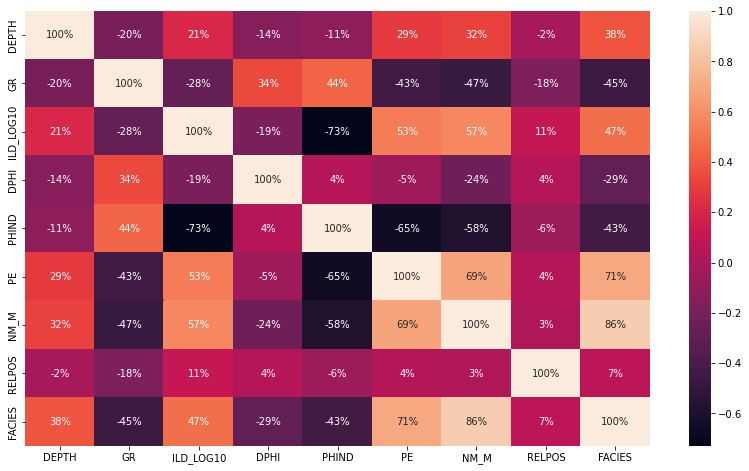

In [ ]:
import seaborn as sns
plt.figure(figsize=(14,8))
sns.heatmap(training.corr('spearman'), annot=True, fmt='.0%')

It seems that the best correlation of target label(facies) belongs to geological factor of NM_M with 86% agreement. PE, which is lithology loging tools shows 70%.

## Data Preprocessing

We need to prepare feature matrix and target matrix. **Feature matrix** `x` will include 5 wireline readings (GR, ILD_LOG10, DPHI, PHIND, RELPOS) and 2 geological constraining variables. **Target matrix** `y` will include FACIES category.

In [ ]:
y = training['FACIES'].values
X = training.drop(['FORMATION', 'WELL', 'DEPTH', 'FACIES'], axis=1)

In [ ]:
X.columns

Index(['GR', 'ILD_LOG10', 'DPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'], dtype='object')

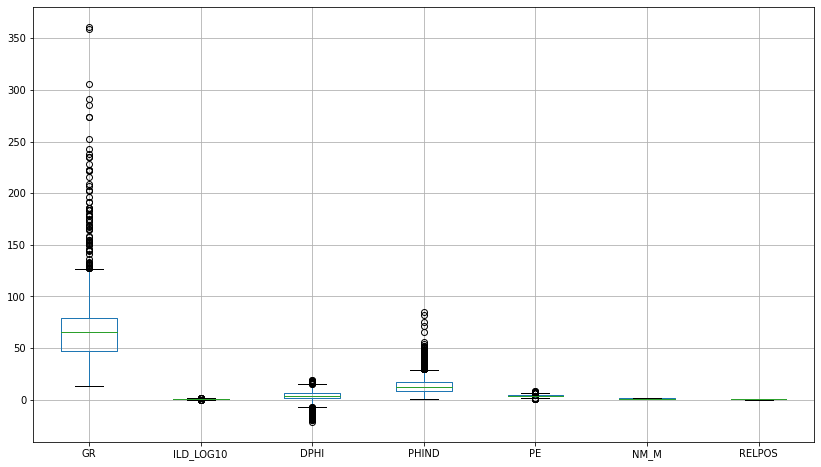

In [ ]:
plt.figure(figsize=(14,8))
X.boxplot()

### Data splitting

Using Scikit data split function, we may randomly split the training data into training and test sets. We select 20% of the data for the test set.

Note:
*   It is suggested to perform splitting before standardization to prevent information leakage
*   Since we already have the "blind set", we may skip `train_test_split` to create test set (as a blind set) and use cross validation during model selection



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_test.describe()

,GR,ILD_LOG10,DPHI,PHIND,PE,NM_M,RELPOS
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,66.633780,0.634056,3.683970,14.087379,3.665124,1.501773,0.518041
std,32.877957,0.249133,5.586356,8.609591,0.853444,0.500441,0.295755
min,13.530000,-0.025949,-19.900000,0.550000,0.646000,1.000000,0.015000
25%,47.047250,0.465844,1.200000,8.587750,3.100000,1.000000,0.263000
50%,65.155000,0.620724,3.900000,12.467500,3.554500,2.000000,0.527500
75%,78.955000,0.810000,6.700000,17.175000,4.249250,2.000000,0.787500
max,361.150000,1.360000,18.500000,84.400000,6.941000,2.000000,1.000000


Compare the boxplot for feature matrix before and after standardization. **Before standardization**, features have different scale.

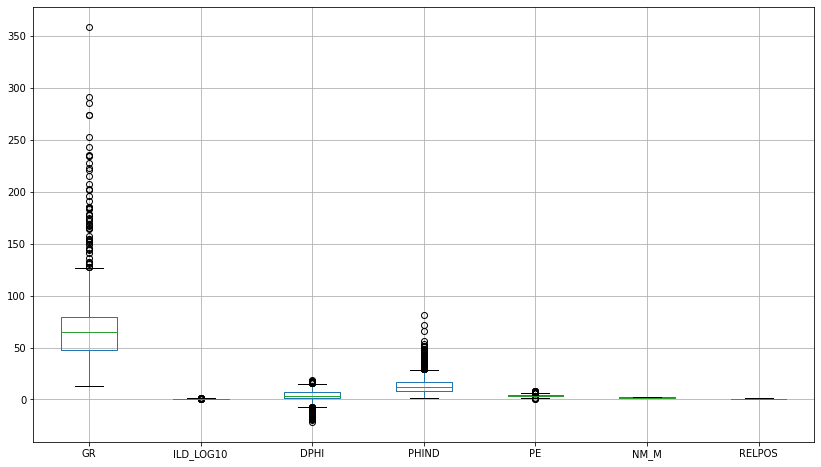

In [ ]:
plt.figure(figsize=(14,8))
X_train.boxplot()

### Standardization

Almost all machine learning models work efficenctly when data is standardized for zero mean and unit variance. Using Scikit preprocessing module:

In [ ]:
from sklearn.preprocessing import StandardScaler

# create StandardScaler instance
scaler = StandardScaler()

# train the scaler to fit X_train
scaler.fit(X_train)

# create transformed X_train_scaled
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)

Compare the boxplot for feature matrix before and after standardization. **After standardization**, features have similar scale.

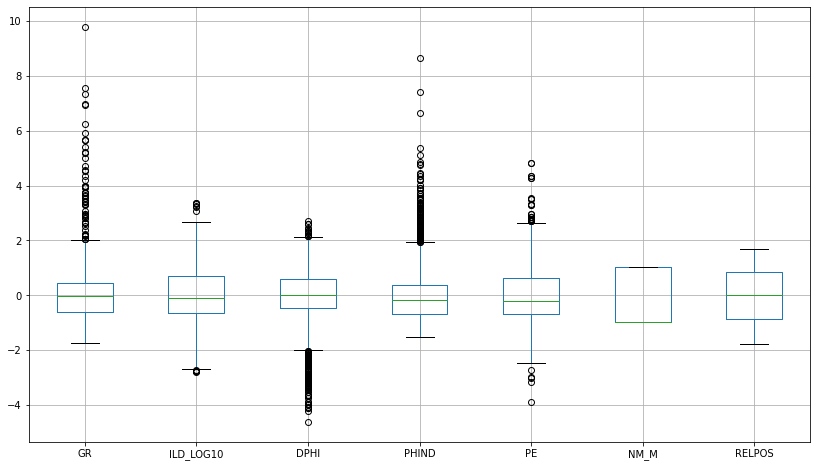

In [ ]:
plt.figure(figsize=(14,8))
X_train_scaled.boxplot()

In [ ]:
# some attributes of StandardScaler
scaler.mean_  # mean
scaler.var_   # variance
scaler.n_samples_seen_  # sample number
scaler.scale_ # feature relative scaling to achieve zero mean and unit variance

array([29.94473984,  0.24440613,  5.50339438,  7.85949078,  0.90768729,
        0.49993966,  0.28449084])

# MODELING USING SUPPORT VECTOR

## Modeling (Simple)

There are [several](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) model approaches/ algorithms that can be used for Facies classificaiton. Explanation the basic concept behind each methods and pros/cons of them can be found in sklearn documentation.

In [ ]:
from sklearn.svm import SVC

# create Support Vector Classifier model, use default parameter
model = SVC()

# training using train data
model.fit(X_train_scaled, y_train)

# don't forget to standardize the X_test first
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# predict result
y_pred = model.predict(X_test_scaled)

Sometimes, we want to know the score/ model performed using training dataset

In [ ]:
from sklearn.metrics import accuracy_score

# score on training set (seen by model during training)
accuracy_score(y_train, model.predict(X_train_scaled))

0.6750998668442078

### Model Evaluation
To see how our model perform during prediction

Reference: [Metric and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

**Accuracy**

Compared with score on training set, test set usually has lower score

In [ ]:
from sklearn.metrics import accuracy_score

# score on test set (never seen by model during training)
accuracy_score(y_test, y_pred)

0.6400709219858156

**Confusion Matrix**

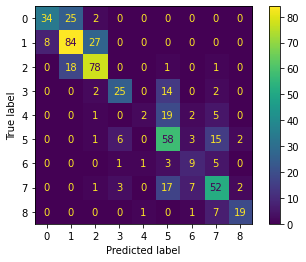

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

The confusion matrix has rows and columns. The rows correspond to actual facies labels and columns show model prediction results. As high value as a possible outcome of the model in diagonal of the matrix, as good as model prediction perfromance.

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.56      0.66        61
           2       0.66      0.71      0.68       119
           3       0.70      0.80      0.74        98
           4       0.71      0.58      0.64        43
           5       0.50      0.07      0.12        29
           6       0.52      0.68      0.59        85
           7       0.41      0.47      0.44        19
           8       0.60      0.63      0.62        82
           9       0.83      0.68      0.75        28

    accuracy                           0.64       564
   macro avg       0.64      0.58      0.58       564
weighted avg       0.65      0.64      0.63       564



**Cross Validation Score**

We've used the data only once for training based on a single randomly selected X_train data from X. Let's explore other possibility for different set of X and y data splitting.

`cross_val_score` from `model_selection` can be used to display various cross validation score, including:
* `f1`, `f1_micro`, and `f1_macro`
* `accuracy`
* `precision`
* `recall`
* `roc_auc`

Note: differentiate which metrics is applicable for multiclass/ single class classification

Reference: [sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, scaler.transform(X), y, scoring='accuracy', cv=5)
scores

array([0.54078014, 0.62765957, 0.53641208, 0.43161634, 0.57904085])

In [ ]:
scores.mean()

0.5431017976140986

In [ ]:
scores.std()

0.06468505663553864

## Modeling (with Hyperparameter Tuning)

So far, we've explore the simple Support Vector Classifier model using default hyperparameter setup. What if we can optimize the hyperparameter setup?

Reference about grid search: [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Reference about SVC model: [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_distributions = {'C': np.arange(1, 11, 2),
                       'kernel': ['linear', 'poly', 'rbf']}
grid_search = GridSearchCV(SVC(),
                           param_distributions,
                           scoring='accuracy',
                           cv=10)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1, 3, 5, 7, 9]),
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [ ]:
# display best hyperparameter configuration
grid_search.best_params_

{'C': 7, 'kernel': 'rbf'}

In [ ]:
# display result
pd.DataFrame(grid_search.cv_results_).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
mean_fit_time,0.23169,0.261081,0.19192,0.139918,0.118568,0.145975,0.192361,0.126941,0.132075,0.209486,0.134126,0.129596,0.236797,0.148923,0.133543
std_fit_time,0.050209,0.044364,0.060989,0.008286,0.004593,0.034183,0.056216,0.006795,0.006528,0.016632,0.005011,0.003652,0.015111,0.010732,0.006945
mean_score_time,0.029841,0.034434,0.042866,0.014973,0.014982,0.034547,0.014568,0.014718,0.027806,0.015306,0.014094,0.026803,0.014369,0.013679,0.025715
std_score_time,0.011175,0.012641,0.020551,0.000997,0.000996,0.013202,0.000585,0.001932,0.003188,0.001341,0.000475,0.002697,0.000634,0.000184,0.000515
param_C,1,1,1,3,3,3,5,5,5,7,7,7,9,9,9
param_kernel,linear,poly,rbf,linear,poly,rbf,linear,poly,rbf,linear,poly,rbf,linear,poly,rbf
params,"{'C': 1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'poly'}","{'C': 1, 'kernel': 'rbf'}","{'C': 3, 'kernel': 'linear'}","{'C': 3, 'kernel': 'poly'}","{'C': 3, 'kernel': 'rbf'}","{'C': 5, 'kernel': 'linear'}","{'C': 5, 'kernel': 'poly'}","{'C': 5, 'kernel': 'rbf'}","{'C': 7, 'kernel': 'linear'}","{'C': 7, 'kernel': 'poly'}","{'C': 7, 'kernel': 'rbf'}","{'C': 9, 'kernel': 'linear'}","{'C': 9, 'kernel': 'poly'}","{'C': 9, 'kernel': 'rbf'}"
split0_test_score,0.584071,0.575221,0.641593,0.59292,0.623894,0.69469,0.59292,0.632743,0.699115,0.59292,0.641593,0.712389,0.59292,0.632743,0.690265
split1_test_score,0.570796,0.623894,0.659292,0.570796,0.685841,0.681416,0.579646,0.690265,0.70354,0.579646,0.69469,0.716814,0.579646,0.712389,0.725664
split2_test_score,0.504425,0.561947,0.579646,0.50885,0.584071,0.60177,0.50885,0.584071,0.615044,0.513274,0.584071,0.628319,0.513274,0.579646,0.628319


### Model Evaluation (on Test Set using Tuned Model)

After we know the best recipe of hyperparameter setup for our SVC model, we'll use the C and kernel type on Test Set

In [ ]:
# obtain tuned model
model_tuned = grid_search.best_estimator_

# train (because we can't predict without training; tuning is not considered as training)
model_tuned.fit(X_train_scaled, y_train)
y_pred = model_tuned.predict(scaler.transform(X_test))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


**Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6453900709219859

**Confusion Matrix**

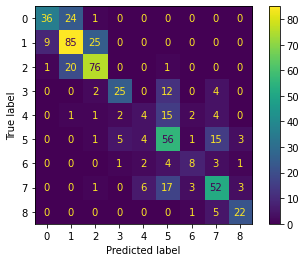

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.59      0.67        61
           2       0.65      0.71      0.68       119
           3       0.71      0.78      0.74        98
           4       0.76      0.58      0.66        43
           5       0.25      0.14      0.18        29
           6       0.53      0.66      0.59        85
           7       0.53      0.42      0.47        19
           8       0.63      0.63      0.63        82
           9       0.76      0.79      0.77        28

    accuracy                           0.65       564
   macro avg       0.62      0.59      0.60       564
weighted avg       0.64      0.65      0.64       564



### Model Inspection

Predictive performance is often the main goal of developing machine learning models. Yet summarizing performance with an evaluation metric is often insufficient: it assumes that the evaluation metric and test dataset perfectly reflect the target domain, which is rarely true. In certain domains, a model needs a certain level of interpretability before it can be deployed. A model that is exhibiting performance issues needs to be debugged for one to understand the model’s underlying issue. The `sklearn.inspection` module provides tools to help understand the predictions from a model and what affects them. This can be used to evaluate assumptions and biases of a model, design a better model, or to diagnose issues with model performance.

Reference:
* [sklearn.inspection](https://scikit-learn.org/stable/inspection.html)
* [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

**Permulation Feature Importance on Training Set**

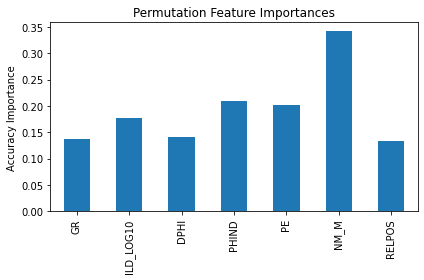

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(model_tuned, X_train_scaled, y_train, n_repeats=5, scoring='accuracy')
feature_names = X.columns
model_importances = pd.Series(result.importances_mean, feature_names)

fig, ax = plt.subplots()
model_importances.plot.bar(ax=ax)
ax.set_title('Permutation Feature Importances')
ax.set_ylabel('Accuracy Importance')
fig.tight_layout()
plt.show()

**Permutation Feature Importance on Test Set**

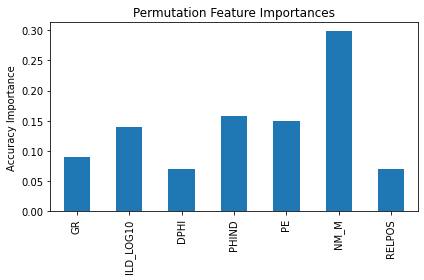

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(model_tuned, X_test_scaled, y_test, n_repeats=5, scoring='accuracy')
feature_names = X.columns
model_importances = pd.Series(result.importances_mean, feature_names)

fig, ax = plt.subplots()
model_importances.plot.bar(ax=ax)
ax.set_title('Permutation Feature Importances')
ax.set_ylabel('Accuracy Importance')
fig.tight_layout()
plt.show()

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

The ranking of the features is approximately the same for different metrics even if the scales of the importance values are very different. However, this is not guaranteed and different metrics might lead to significantly different feature importances, in particular for models trained for imbalanced classification problems, for which the choice of the classification metric can be critical.

**Warning:** Features that are deemed of **low importance for a bad model** (low cross-validation score) could be **very important for a good model**. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself **but how important this feature is for a particular model**.

## Model Deployment on Blind Set

### Prediction using tuned model

In [ ]:
# create feature matrix and target matrix from blind set
y_blind = blind['FACIES'].values
X_blind = blind.drop(['FORMATION', 'WELL', 'DEPTH', 'FACIES'], axis=1)

In [ ]:
# don't forget to transform the feature matrix before prediction
X_blind_scaled = scaler.transform(X_blind)

In [ ]:
# perform prediction
y_blind_pred = model_tuned.predict(X_blind_scaled)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


### Model Evaluation on Blind Set

**Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_blind, y_blind_pred)

0.4843373493975904

**Confusion Matrix**

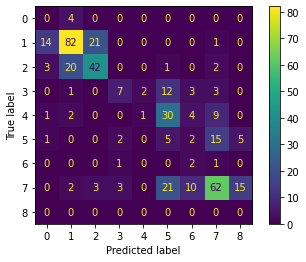

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_blind, y_blind_pred)
ConfusionMatrixDisplay(cm).plot()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_blind, y_blind_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.74      0.69      0.72       118
           3       0.64      0.62      0.63        68
           4       0.54      0.25      0.34        28
           5       0.33      0.02      0.04        47
           6       0.07      0.17      0.10        30
           7       0.10      0.50      0.16         4
           8       0.67      0.53      0.59       116
           9       0.00      0.00      0.00         0

    accuracy                           0.48       415
   macro avg       0.34      0.31      0.29       415
weighted avg       0.58      0.48      0.51       415



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


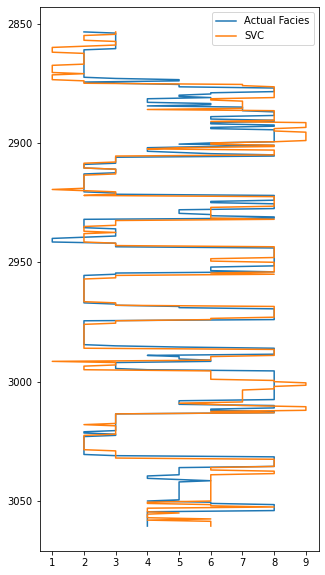

In [ ]:
figure, ax = plt.subplots(figsize=(5,10))
logs = blind.sort_values(by='DEPTH')
ax.plot(logs.FACIES, logs.DEPTH, label='Actual Facies')
ax.plot(y_blind_pred, logs.DEPTH, label='SVC')
ax.invert_yaxis()
ax.legend()

### Model Inspection on Blind Set

**Permutation Feature Importance**

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local

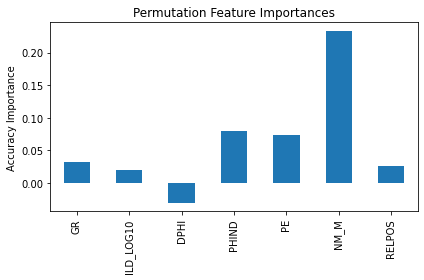

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(model_tuned, X_blind_scaled, y_blind, n_repeats=5, scoring='accuracy')
feature_names = X.columns
model_importances = pd.Series(result.importances_mean, feature_names)

fig, ax = plt.subplots()
model_importances.plot.bar(ax=ax)
ax.set_title('Permutation Feature Importances')
ax.set_ylabel('Accuracy Importance')
fig.tight_layout()
plt.show()

# MODELING USING K-NEAREST NEIGHBOR

## Modeling (Simple)

There are [several](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) model approaches/ algorithms that can be used for Facies classificaiton. Explanation the basic concept behind each methods and pros/cons of them can be found in sklearn documentation.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# create Support Vector Classifier model, use default parameter
model = KNeighborsClassifier()

# training using train data
model.fit(X_train_scaled, y_train)

# don't forget to standardize the X_test first
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# predict result
y_pred = model.predict(X_test_scaled)

### Model Evaluation
To see how our model perform during prediction

Reference: [Metric and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

**Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.7109929078014184

**Confusion Matrix**

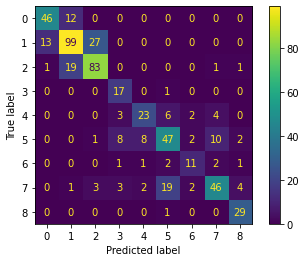

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

The confusion matrix has rows and columns. The rows correspond to actual facies labels and columns show model prediction results. As high value as a possible outcome of the model in diagonal of the matrix, as good as model prediction perfromance.

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.79      0.78        58
           2       0.76      0.71      0.73       139
           3       0.73      0.79      0.76       105
           4       0.53      0.94      0.68        18
           5       0.68      0.61      0.64        38
           6       0.62      0.60      0.61        78
           7       0.65      0.61      0.63        18
           8       0.73      0.57      0.64        80
           9       0.78      0.97      0.87        30

    accuracy                           0.71       564
   macro avg       0.69      0.73      0.70       564
weighted avg       0.71      0.71      0.71       564



**Cross Validation Score**

We've used the data only once for training based on a single randomly selected X_train data from X. Let's explore other possibility for different set of X and y data splitting.

`cross_val_score` from `model_selection` can be used to display various cross validation score, including:
* `f1`, `f1_micro`, and `f1_macro`
* `accuracy`
* `precision`
* `recall`
* `roc_auc`

Note: differentiate which metrics is applicable for multiclass/ single class classification

Reference: [sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, scaler.transform(X), y, scoring='accuracy', cv=5)
scores

array([0.47695035, 0.54255319, 0.45115453, 0.39964476, 0.51154529])

In [ ]:
scores.mean()

0.4763696257385083

In [ ]:
scores.std()

0.04927562332808253

## Modeling (with Hyperparameter Tuning)

So far, we've explore the simple model using default hyperparameter setup. What if we can optimize the hyperparameter setup?

Reference about grid search: [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Reference about KNeighborsClassifier model: [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_distributions = {'n_neighbors': np.arange(5, 21, 5),
                       'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_distributions,
                           scoring='accuracy',
                           cv=10)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 5, 10, 15, 20]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
# display best hyperparameter configuration
grid_search.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

In [ ]:
# display result
pd.DataFrame(grid_search.cv_results_).transpose()

,0,1,2,3,4,5,6,7
mean_fit_time,0.004003,0.003394,0.003635,0.004056,0.003694,0.003635,0.00412,0.003946
std_fit_time,0.000887,0.000082,0.00047,0.000985,0.000309,0.000375,0.001214,0.000516
mean_score_time,0.011652,0.004391,0.010625,0.005562,0.010951,0.006085,0.0127,0.007228
std_score_time,0.002655,0.000197,0.002001,0.000826,0.000588,0.000533,0.003895,0.001464
param_n_neighbors,5,5,10,10,15,15,20,20
param_weights,uniform,distance,uniform,distance,uniform,distance,uniform,distance
params,"{'n_neighbors': 5, 'weights': 'uniform'}","{'n_neighbors': 5, 'weights': 'distance'}","{'n_neighbors': 10, 'weights': 'uniform'}","{'n_neighbors': 10, 'weights': 'distance'}","{'n_neighbors': 15, 'weights': 'uniform'}","{'n_neighbors': 15, 'weights': 'distance'}","{'n_neighbors': 20, 'weights': 'uniform'}","{'n_neighbors': 20, 'weights': 'distance'}"
split0_test_score,0.69469,0.730088,0.615044,0.70354,0.623894,0.690265,0.632743,0.699115
split1_test_score,0.712389,0.756637,0.685841,0.734513,0.650442,0.712389,0.641593,0.707965
split2_test_score,0.725664,0.752212,0.690265,0.721239,0.615044,0.676991,0.619469,0.672566


### Model Evaluation (on Test Set using Tuned Model)

After we know the best recipe of hyperparameter setup for our SVC model, we'll use the C and kernel type on Test Set

In [ ]:
# obtain tuned model
model_tuned = grid_search.best_estimator_

# train (because we can't predict without training; tuning is not considered as training)
model_tuned.fit(X_train_scaled, y_train)
y_pred = model_tuned.predict(scaler.transform(X_test))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


**Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.7304964539007093

**Confusion Matrix**

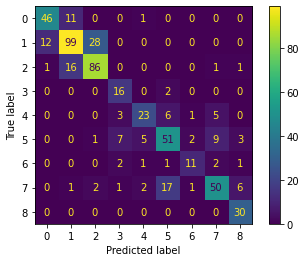

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.79      0.79        58
           2       0.78      0.71      0.74       139
           3       0.74      0.82      0.77       105
           4       0.55      0.89      0.68        18
           5       0.72      0.61      0.66        38
           6       0.66      0.65      0.66        78
           7       0.73      0.61      0.67        18
           8       0.75      0.62      0.68        80
           9       0.73      1.00      0.85        30

    accuracy                           0.73       564
   macro avg       0.72      0.75      0.72       564
weighted avg       0.73      0.73      0.73       564



### Model Inspection

Predictive performance is often the main goal of developing machine learning models. Yet summarizing performance with an evaluation metric is often insufficient: it assumes that the evaluation metric and test dataset perfectly reflect the target domain, which is rarely true. In certain domains, a model needs a certain level of interpretability before it can be deployed. A model that is exhibiting performance issues needs to be debugged for one to understand the model’s underlying issue. The `sklearn.inspection` module provides tools to help understand the predictions from a model and what affects them. This can be used to evaluate assumptions and biases of a model, design a better model, or to diagnose issues with model performance.

Reference:
* [sklearn.inspection](https://scikit-learn.org/stable/inspection.html)
* [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

**Permulation Feature Importance on Training Set**

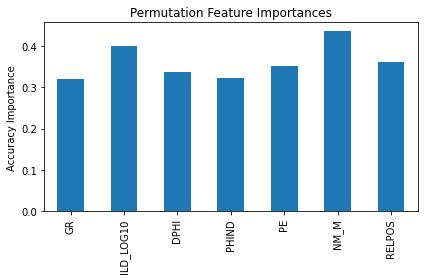

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(model_tuned, X_train_scaled, y_train, n_repeats=5, scoring='accuracy')
feature_names = X.columns
model_importances = pd.Series(result.importances_mean, feature_names)

fig, ax = plt.subplots()
model_importances.plot.bar(ax=ax)
ax.set_title('Permutation Feature Importances')
ax.set_ylabel('Accuracy Importance')
fig.tight_layout()
plt.show()

**Permutation Feature Importance on Test Set**

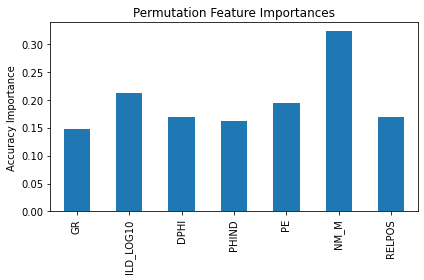

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(model_tuned, X_test_scaled, y_test, n_repeats=5, scoring='accuracy')
feature_names = X.columns
model_importances = pd.Series(result.importances_mean, feature_names)

fig, ax = plt.subplots()
model_importances.plot.bar(ax=ax)
ax.set_title('Permutation Feature Importances')
ax.set_ylabel('Accuracy Importance')
fig.tight_layout()
plt.show()

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

The ranking of the features is approximately the same for different metrics even if the scales of the importance values are very different. However, this is not guaranteed and different metrics might lead to significantly different feature importances, in particular for models trained for imbalanced classification problems, for which the choice of the classification metric can be critical.

**Warning:** Features that are deemed of **low importance for a bad model** (low cross-validation score) could be **very important for a good model**. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself **but how important this feature is for a particular model**.

## Model Deployment on Blind Set

### Prediction using tuned model

In [ ]:
# create feature matrix and target matrix from blind set
y_blind = blind['FACIES'].values
X_blind = blind.drop(['FORMATION', 'WELL', 'DEPTH', 'FACIES'], axis=1)

In [ ]:
# don't forget to transform the feature matrix before prediction
X_blind_scaled = scaler.transform(X_blind)

In [ ]:
# perform prediction
y_blind_pred = model_tuned.predict(X_blind_scaled)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


### Model Evaluation on Blind Set

**Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_blind, y_blind_pred)

0.4602409638554217

**Confusion Matrix**

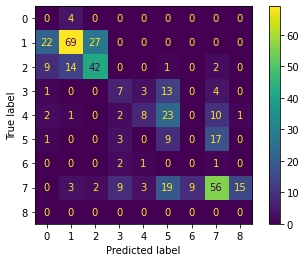

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_blind, y_blind_pred)
ConfusionMatrixDisplay(cm).plot()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_blind, y_blind_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.76      0.58      0.66       118
           3       0.59      0.62      0.60        68
           4       0.30      0.25      0.27        28
           5       0.53      0.17      0.26        47
           6       0.14      0.30      0.19        30
           7       0.00      0.00      0.00         4
           8       0.62      0.48      0.54       116
           9       0.00      0.00      0.00         0

    accuracy                           0.46       415
   macro avg       0.33      0.27      0.28       415
weighted avg       0.58      0.46      0.50       415



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


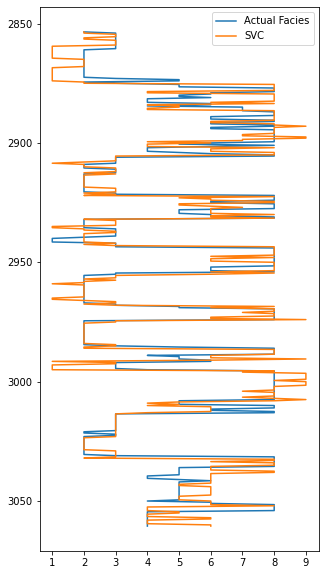

In [ ]:
figure, ax = plt.subplots(figsize=(5,10))
logs = blind.sort_values(by='DEPTH')
ax.plot(logs.FACIES, logs.DEPTH, label='Actual Facies')
ax.plot(y_blind_pred, logs.DEPTH, label='SVC')
ax.invert_yaxis()
ax.legend()

### Model Inspection on Blind Set

**Permutation Feature Importance**

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have v

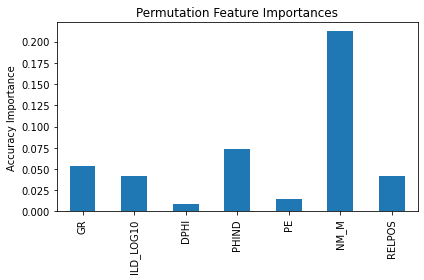

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(model_tuned, X_blind_scaled, y_blind, n_repeats=5, scoring='accuracy')
feature_names = X.columns
model_importances = pd.Series(result.importances_mean, feature_names)

fig, ax = plt.subplots()
model_importances.plot.bar(ax=ax)
ax.set_title('Permutation Feature Importances')
ax.set_ylabel('Accuracy Importance')
fig.tight_layout()
plt.show()

# ADDITIONAL: LEARNING CURVE AND VALIDATION CURVE

### Learning Curve

**Learning Curve** visualize the trade-off between bias and variance, and its dependence on training set size. Here, we will vary the training/validation set size to explore the behavior of the model score as a function of **the number of training points**, which can be done by using increasingly larger subsets of the data to fit our model. Hopefully, we can address the question of *whether adding more training data will help our model*.

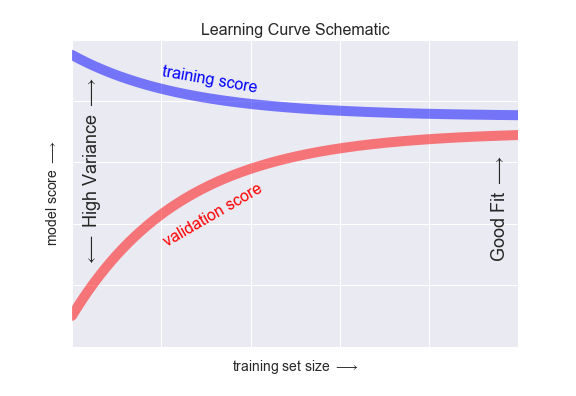

The general behavior from a learning curve:
* A model of a given complexity will **overfit a small dataset**: this means the training score will be relatively high, while the validation score will be relatively low.
* A model of a given complexity will **underfit a large dataset**: this means that the training score will decrease, but the validation score will increase.
* A model will **never**, except by chance, **give a better score to the validation set than the training set**: this means the curves should keep getting closer together but never cross.

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np

In [ ]:
train_sizes = np.linspace(0.05, 1, 9)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model_tuned,
                                                                   X_train_scaled,
                                                                   y_train,
                                                                   cv=10,
                                                                   train_sizes=train_sizes,
                                                                   return_times=True)

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

Text(0, 0.5, 'Score')

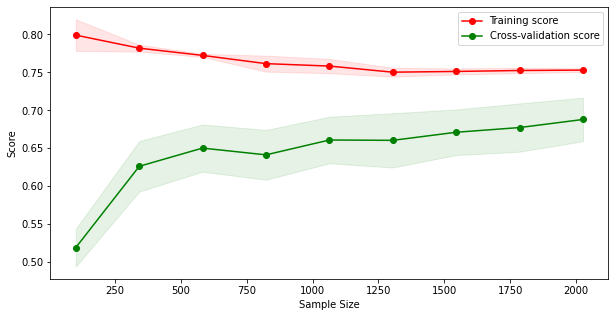

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
axes.fill_between(train_sizes,
                  train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std,
                  alpha=0.1,
                  color="r")
axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
axes.fill_between(train_sizes,
                  test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std,
                  alpha=0.1,
                  color="g")
axes.legend()
# axes.set_ylim(0.8, 1)
axes.set_xlabel('Sample Size')
axes.set_ylabel('Score')

### Validation Curve

**Validation Curve** visualize the trade-off between bias and variance, and its dependence on model complexity. Here, we will vary the hyperparameters and evaluate its effect on training and validation score.
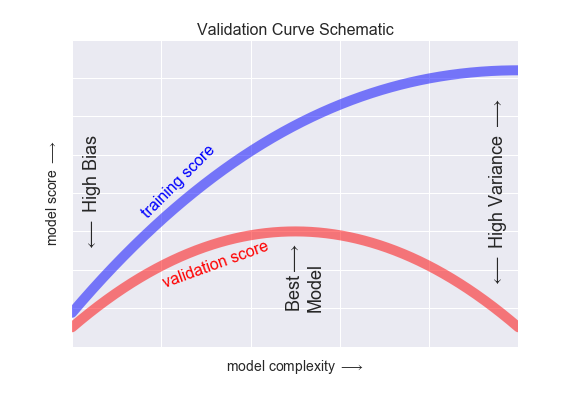

In [ ]:
import numpy as np
from sklearn.model_selection import validation_curve

In [ ]:
param_range = np.linspace(1,11,10)
train_scores, valid_scores = validation_curve(model_tuned,
                                              X_train_scaled, y_train,
                                              param_name='C',
                                              param_range=param_range,
                                              cv=5)

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

Text(0, 0.5, 'Score')

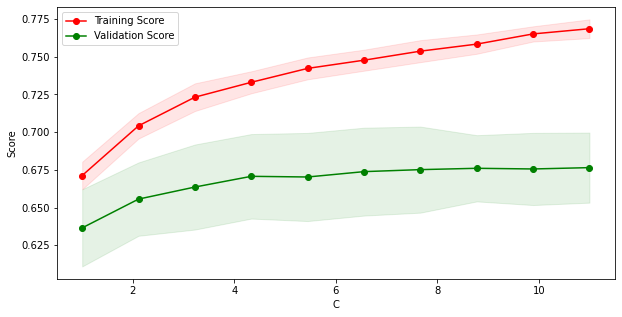

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(param_range, train_scores_mean, 'o-', label='Training Score', color='red')
axes.fill_between(param_range,
                  train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std,
                  alpha=0.1,
                  color="r")
axes.plot(param_range,
          valid_scores_mean, 'o-',
          label='Validation Score',
          color='green')
axes.fill_between(param_range,
                  valid_scores_mean - valid_scores_std,
                  valid_scores_mean + valid_scores_std,
                  alpha=0.1,
                  color="green")
axes.legend()
# axes.set_ylim(0.8, 1)
axes.set_xlabel('C')
axes.set_ylabel('Score')